In [ ]:
!pip install segmentation_models_pytorch

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#models.segmentation.fcn_resnet50" data-toc-modified-id="models.segmentation.fcn_resnet50-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>models.segmentation.fcn_resnet50</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span><ul class="toc-item"><li><span><a href="#plot_examples()-시각화-함수-정의" data-toc-modified-id="plot_examples()-시각화-함수-정의-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span><code>plot_examples()</code> 시각화 함수 정의</a></span><ul class="toc-item"><li><span><a href="#train-set-시각화" data-toc-modified-id="train-set-시각화-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>train set 시각화</a></span></li><li><span><a href="#validation-set-시각화" data-toc-modified-id="validation-set-시각화-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>validation set 시각화</a></span></li><li><span><a href="#test-set-시각화" data-toc-modified-id="test-set-시각화-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>test set 시각화</a></span></li></ul></li></ul></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li></ul></div>

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.9.1+cu102
GPU 사용 가능 여부: True
Tesla V100-SXM2-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 16   # Mini-batch size
num_epochs = 50
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [4]:
%matplotlib inline

dataset_path  = '../input'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 20988
Number of images: 2617


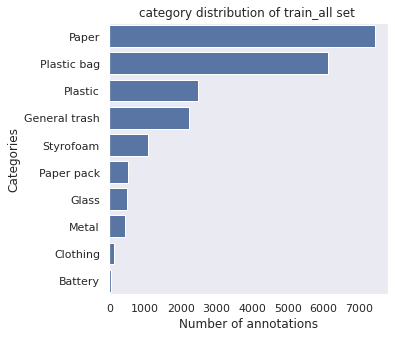

In [5]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [6]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [7]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2225.0
2,Paper,7448.0
3,Paper pack,527.0
4,Metal,449.0
5,Glass,488.0
6,Plastic,2472.0
7,Styrofoam,1074.0
8,Plastic bag,6114.0
9,Battery,50.0


## 데이터 전처리 함수 정의 (Dataset)

In [8]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [9]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.augmentations.geometric.rotate import RandomRotate90
from albumentations.augmentations.transforms import HorizontalFlip, VerticalFlip
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        A.RandomGridShuffle(p=1.0),
                        A.HorizontalFlip(p=1.0),
                        A.VerticalFlip(p=1.0),
                        A.RandomRotate90(p=1.0),
                        A.Cutout(p=0.75),
                        ToTensorV2()
                        ])

val_transform = A.Compose([
                        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()
                        ])

test_transform = A.Compose([
                        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()
                        ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=0,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=0,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.90s)
creating index...
index created!
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [10]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [11]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {1, 'General trash'}, {2, 'Paper'}, {8, 'Plastic bag'}]


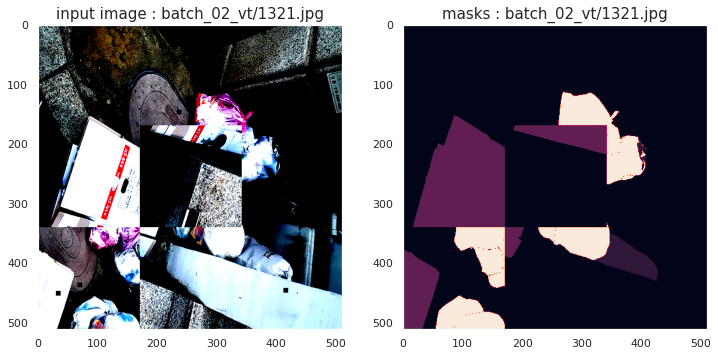

In [12]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 5}, {6, 'Plastic'}, {8, 'Plastic bag'}]


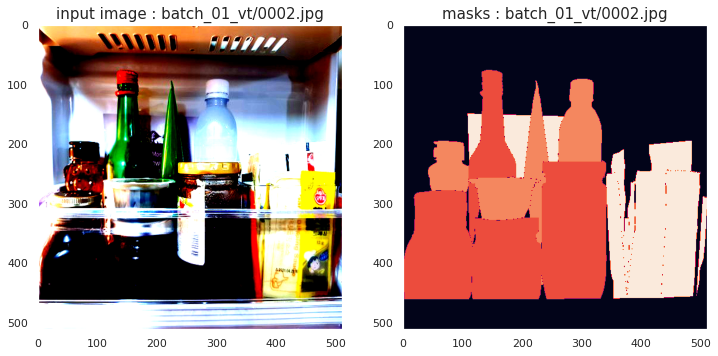

In [13]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: [3, 512, 512]


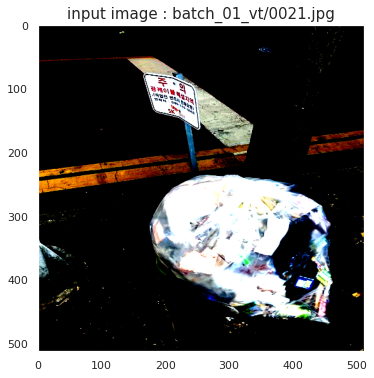

In [14]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### models.segmentation.fcn_resnet50

In [15]:
import torch
import segmentation_models_pytorch as smp

In [16]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model = smp.DeepLabV3Plus(encoder_name="resnext50_32x4d",encoder_weights="imagenet",in_channels=3,classes=11).to(device)
# output class를 data set에 맞도록 수정
# model.classifier[4] = nn.Conv2d(256, 11, kernel_size=1)
print(model)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [17]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
x = torch.randn([2, 3, 512, 512]).to(device)
print(f"input shape : {x.shape}")
out = model(x)
print(f"output shape : {out.size()}")

input shape : torch.Size([2, 3, 512, 512])
output shape : torch.Size([2, 11, 512, 512])


## train, validation, test 함수 정의

In [18]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print(f'Start training..')
    n_class = 11
    best_loss = 9999999
    
    for epoch in range(num_epochs):
        model.train()

        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       
            masks = torch.stack(masks).long() 
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # device 할당
            model = model.to(device)
            
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
            
            # step 주기에 따른 loss 출력
            if (step + 1) % batch_size == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], \
                        Loss: {round(loss.item(),4)}, mIoU: {round(mIoU,4)}')
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [19]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in tqdm(enumerate(data_loader)):
            
            images = torch.stack(images)       
            masks = torch.stack(masks).long()  

            images, masks = images.to(device), masks.to(device)            
            
            # device 할당
            model = model.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]
        
        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch}  Average Loss: {round(avrg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                mIoU: {round(mIoU, 4)}')
        print(f'IoU by class : {IoU_by_class}')
        
    return avrg_loss

## 모델 저장 함수 정의

In [20]:
# 모델 저장 함수 정의
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name='resnext50_32x4d_epo50.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [21]:
from pytorch_toolbelt import losses

In [22]:
# Loss function 정의
criterion = losses.SoftCrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = torch.optim.AdamW(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [23]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/50], Step [16/164],                         Loss: 1.7283, mIoU: 0.0966
Epoch [1/50], Step [32/164],                         Loss: 1.2109, mIoU: 0.1314
Epoch [1/50], Step [48/164],                         Loss: 1.1294, mIoU: 0.1458
Epoch [1/50], Step [64/164],                         Loss: 0.9739, mIoU: 0.1558
Epoch [1/50], Step [80/164],                         Loss: 0.8702, mIoU: 0.1635
Epoch [1/50], Step [96/164],                         Loss: 0.7511, mIoU: 0.1704
Epoch [1/50], Step [112/164],                         Loss: 0.698, mIoU: 0.1781
Epoch [1/50], Step [128/164],                         Loss: 0.7105, mIoU: 0.183
Epoch [1/50], Step [144/164],                         Loss: 0.6168, mIoU: 0.1872
Epoch [1/50], Step [160/164],                         Loss: 0.5071, mIoU: 0.191


0it [00:00, ?it/s]

Start validation #1


41it [00:23,  1.98it/s]


Validation #1  Average Loss: 0.5202, Accuracy : 0.8811,                 mIoU: 0.3255
IoU by class : [{'Backgroud': 0.9206}, {'General trash': 0.2226}, {'Paper': 0.6035}, {'Paper pack': 0.0}, {'Metal': 0.0001}, {'Glass': 0.3676}, {'Plastic': 0.297}, {'Styrofoam': 0.4219}, {'Plastic bag': 0.7467}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 1
Save model in ./saved
Epoch [2/50], Step [16/164],                         Loss: 0.6451, mIoU: 0.2823
Epoch [2/50], Step [32/164],                         Loss: 0.5345, mIoU: 0.2797
Epoch [2/50], Step [48/164],                         Loss: 0.6145, mIoU: 0.2922
Epoch [2/50], Step [64/164],                         Loss: 0.6056, mIoU: 0.2964
Epoch [2/50], Step [80/164],                         Loss: 0.5414, mIoU: 0.2936
Epoch [2/50], Step [96/164],                         Loss: 0.4328, mIoU: 0.2957
Epoch [2/50], Step [112/164],                         Loss: 0.5203, mIoU: 0.2954
Epoch [2/50], Step [128/164],                         

0it [00:00, ?it/s]

Start validation #2


41it [00:24,  1.79it/s]


Validation #2  Average Loss: 0.3838, Accuracy : 0.8964,                 mIoU: 0.3798
IoU by class : [{'Backgroud': 0.9305}, {'General trash': 0.3136}, {'Paper': 0.6673}, {'Paper pack': 0.1098}, {'Metal': 0.0981}, {'Glass': 0.3638}, {'Plastic': 0.3509}, {'Styrofoam': 0.5664}, {'Plastic bag': 0.7728}, {'Battery': 0.0}, {'Clothing': 0.0046}]
Best performance at epoch: 2
Save model in ./saved
Epoch [3/50], Step [16/164],                         Loss: 0.4925, mIoU: 0.34
Epoch [3/50], Step [32/164],                         Loss: 0.497, mIoU: 0.3432
Epoch [3/50], Step [48/164],                         Loss: 0.5155, mIoU: 0.3564
Epoch [3/50], Step [64/164],                         Loss: 0.3362, mIoU: 0.3602
Epoch [3/50], Step [80/164],                         Loss: 0.4911, mIoU: 0.3678
Epoch [3/50], Step [96/164],                         Loss: 0.3158, mIoU: 0.3693
Epoch [3/50], Step [112/164],                         Loss: 0.4029, mIoU: 0.3669
Epoch [3/50], Step [128/164],                     

0it [00:00, ?it/s]

Start validation #3


41it [00:23,  2.00it/s]


Validation #3  Average Loss: 0.3415, Accuracy : 0.9,                 mIoU: 0.4468
IoU by class : [{'Backgroud': 0.9339}, {'General trash': 0.3262}, {'Paper': 0.6552}, {'Paper pack': 0.298}, {'Metal': 0.3471}, {'Glass': 0.4527}, {'Plastic': 0.3451}, {'Styrofoam': 0.4764}, {'Plastic bag': 0.77}, {'Battery': 0.0}, {'Clothing': 0.3105}]
Best performance at epoch: 3
Save model in ./saved
Epoch [4/50], Step [16/164],                         Loss: 0.4416, mIoU: 0.4668
Epoch [4/50], Step [32/164],                         Loss: 0.2656, mIoU: 0.4539
Epoch [4/50], Step [48/164],                         Loss: 0.2651, mIoU: 0.4567
Epoch [4/50], Step [64/164],                         Loss: 0.3277, mIoU: 0.4717
Epoch [4/50], Step [80/164],                         Loss: 0.3013, mIoU: 0.4725
Epoch [4/50], Step [96/164],                         Loss: 0.3021, mIoU: 0.4645
Epoch [4/50], Step [112/164],                         Loss: 0.3131, mIoU: 0.466
Epoch [4/50], Step [128/164],                         

0it [00:00, ?it/s]

Start validation #4


41it [00:23,  1.98it/s]


Validation #4  Average Loss: 0.2971, Accuracy : 0.9136,                 mIoU: 0.464
IoU by class : [{'Backgroud': 0.9426}, {'General trash': 0.3758}, {'Paper': 0.697}, {'Paper pack': 0.329}, {'Metal': 0.3467}, {'Glass': 0.303}, {'Plastic': 0.3822}, {'Styrofoam': 0.6121}, {'Plastic bag': 0.8006}, {'Battery': 0.0}, {'Clothing': 0.3147}]
Best performance at epoch: 4
Save model in ./saved
Epoch [5/50], Step [16/164],                         Loss: 0.2179, mIoU: 0.4494
Epoch [5/50], Step [32/164],                         Loss: 0.303, mIoU: 0.4679
Epoch [5/50], Step [48/164],                         Loss: 0.4105, mIoU: 0.4622
Epoch [5/50], Step [64/164],                         Loss: 0.3253, mIoU: 0.4815
Epoch [5/50], Step [80/164],                         Loss: 0.3239, mIoU: 0.4867
Epoch [5/50], Step [96/164],                         Loss: 0.2627, mIoU: 0.4846
Epoch [5/50], Step [112/164],                         Loss: 0.2279, mIoU: 0.4863
Epoch [5/50], Step [128/164],                       

0it [00:00, ?it/s]

Start validation #5


41it [00:24,  1.81it/s]


Validation #5  Average Loss: 0.3046, Accuracy : 0.9104,                 mIoU: 0.4631
IoU by class : [{'Backgroud': 0.9432}, {'General trash': 0.353}, {'Paper': 0.7151}, {'Paper pack': 0.2888}, {'Metal': 0.2457}, {'Glass': 0.4377}, {'Plastic': 0.3533}, {'Styrofoam': 0.6119}, {'Plastic bag': 0.8061}, {'Battery': 0.0}, {'Clothing': 0.3397}]
Epoch [6/50], Step [16/164],                         Loss: 0.2323, mIoU: 0.5476
Epoch [6/50], Step [32/164],                         Loss: 0.2739, mIoU: 0.5541
Epoch [6/50], Step [48/164],                         Loss: 0.209, mIoU: 0.5537
Epoch [6/50], Step [64/164],                         Loss: 0.3222, mIoU: 0.5361
Epoch [6/50], Step [80/164],                         Loss: 0.373, mIoU: 0.5309
Epoch [6/50], Step [96/164],                         Loss: 0.2523, mIoU: 0.5258
Epoch [6/50], Step [112/164],                         Loss: 0.2259, mIoU: 0.5283
Epoch [6/50], Step [128/164],                         Loss: 0.1857, mIoU: 0.5234
Epoch [6/50], Step [

0it [00:00, ?it/s]

Start validation #6


41it [00:24,  1.96it/s]


Validation #6  Average Loss: 0.293, Accuracy : 0.9165,                 mIoU: 0.4823
IoU by class : [{'Backgroud': 0.9444}, {'General trash': 0.3731}, {'Paper': 0.7136}, {'Paper pack': 0.3831}, {'Metal': 0.3407}, {'Glass': 0.4511}, {'Plastic': 0.3826}, {'Styrofoam': 0.5841}, {'Plastic bag': 0.8139}, {'Battery': 0.0}, {'Clothing': 0.3186}]
Best performance at epoch: 6
Save model in ./saved
Epoch [7/50], Step [16/164],                         Loss: 0.2237, mIoU: 0.6315
Epoch [7/50], Step [32/164],                         Loss: 0.2957, mIoU: 0.6303
Epoch [7/50], Step [48/164],                         Loss: 0.1875, mIoU: 0.5814
Epoch [7/50], Step [64/164],                         Loss: 0.2792, mIoU: 0.578
Epoch [7/50], Step [80/164],                         Loss: 0.2412, mIoU: 0.5743
Epoch [7/50], Step [96/164],                         Loss: 0.2881, mIoU: 0.5681
Epoch [7/50], Step [112/164],                         Loss: 0.2339, mIoU: 0.5627
Epoch [7/50], Step [128/164],                    

0it [00:00, ?it/s]

Start validation #7


41it [00:24,  1.93it/s]


Validation #7  Average Loss: 0.287, Accuracy : 0.9171,                 mIoU: 0.493
IoU by class : [{'Backgroud': 0.9456}, {'General trash': 0.3651}, {'Paper': 0.725}, {'Paper pack': 0.441}, {'Metal': 0.3654}, {'Glass': 0.4142}, {'Plastic': 0.3457}, {'Styrofoam': 0.6364}, {'Plastic bag': 0.8151}, {'Battery': 0.0}, {'Clothing': 0.369}]
Best performance at epoch: 7
Save model in ./saved
Epoch [8/50], Step [16/164],                         Loss: 0.2549, mIoU: 0.6041
Epoch [8/50], Step [32/164],                         Loss: 0.2008, mIoU: 0.5969
Epoch [8/50], Step [48/164],                         Loss: 0.3535, mIoU: 0.6095
Epoch [8/50], Step [64/164],                         Loss: 0.1657, mIoU: 0.6027
Epoch [8/50], Step [80/164],                         Loss: 0.1604, mIoU: 0.599
Epoch [8/50], Step [96/164],                         Loss: 0.2213, mIoU: 0.6025
Epoch [8/50], Step [112/164],                         Loss: 0.1901, mIoU: 0.6077
Epoch [8/50], Step [128/164],                        

0it [00:00, ?it/s]

Start validation #8


41it [00:22,  2.05it/s]


Validation #8  Average Loss: 0.2826, Accuracy : 0.9189,                 mIoU: 0.492
IoU by class : [{'Backgroud': 0.9454}, {'General trash': 0.3743}, {'Paper': 0.7423}, {'Paper pack': 0.3929}, {'Metal': 0.3886}, {'Glass': 0.456}, {'Plastic': 0.3855}, {'Styrofoam': 0.6284}, {'Plastic bag': 0.7979}, {'Battery': 0.0}, {'Clothing': 0.301}]
Best performance at epoch: 8
Save model in ./saved
Epoch [9/50], Step [16/164],                         Loss: 0.175, mIoU: 0.6875
Epoch [9/50], Step [32/164],                         Loss: 0.2893, mIoU: 0.617
Epoch [9/50], Step [48/164],                         Loss: 0.3677, mIoU: 0.6269
Epoch [9/50], Step [64/164],                         Loss: 0.3062, mIoU: 0.6285
Epoch [9/50], Step [80/164],                         Loss: 0.2351, mIoU: 0.6322
Epoch [9/50], Step [96/164],                         Loss: 0.2258, mIoU: 0.6342
Epoch [9/50], Step [112/164],                         Loss: 0.1823, mIoU: 0.6374
Epoch [9/50], Step [128/164],                       

0it [00:00, ?it/s]

Start validation #9


41it [00:23,  2.01it/s]


Validation #9  Average Loss: 0.2848, Accuracy : 0.9195,                 mIoU: 0.5083
IoU by class : [{'Backgroud': 0.948}, {'General trash': 0.3605}, {'Paper': 0.7169}, {'Paper pack': 0.3641}, {'Metal': 0.3528}, {'Glass': 0.4731}, {'Plastic': 0.4635}, {'Styrofoam': 0.705}, {'Plastic bag': 0.7966}, {'Battery': 0.0}, {'Clothing': 0.4111}]
Epoch [10/50], Step [16/164],                         Loss: 0.1617, mIoU: 0.665
Epoch [10/50], Step [32/164],                         Loss: 0.1588, mIoU: 0.6545
Epoch [10/50], Step [48/164],                         Loss: 0.1519, mIoU: 0.659
Epoch [10/50], Step [64/164],                         Loss: 0.1922, mIoU: 0.6593
Epoch [10/50], Step [80/164],                         Loss: 0.1683, mIoU: 0.6529
Epoch [10/50], Step [96/164],                         Loss: 0.1274, mIoU: 0.6535
Epoch [10/50], Step [112/164],                         Loss: 0.1187, mIoU: 0.6608
Epoch [10/50], Step [128/164],                         Loss: 0.2084, mIoU: 0.6589
Epoch [10/50]

0it [00:00, ?it/s]

Start validation #10


41it [00:24,  1.86it/s]


Validation #10  Average Loss: 0.2913, Accuracy : 0.9189,                 mIoU: 0.4847
IoU by class : [{'Backgroud': 0.9493}, {'General trash': 0.3868}, {'Paper': 0.7424}, {'Paper pack': 0.3957}, {'Metal': 0.3272}, {'Glass': 0.4944}, {'Plastic': 0.3687}, {'Styrofoam': 0.6251}, {'Plastic bag': 0.786}, {'Battery': 0.0}, {'Clothing': 0.2563}]
Epoch [11/50], Step [16/164],                         Loss: 0.2483, mIoU: 0.7041
Epoch [11/50], Step [32/164],                         Loss: 0.2241, mIoU: 0.6532
Epoch [11/50], Step [48/164],                         Loss: 0.134, mIoU: 0.6635
Epoch [11/50], Step [64/164],                         Loss: 0.2328, mIoU: 0.6632
Epoch [11/50], Step [80/164],                         Loss: 0.2086, mIoU: 0.6598
Epoch [11/50], Step [96/164],                         Loss: 0.1581, mIoU: 0.6606
Epoch [11/50], Step [112/164],                         Loss: 0.1102, mIoU: 0.6633
Epoch [11/50], Step [128/164],                         Loss: 0.1583, mIoU: 0.6679
Epoch [11/

0it [00:00, ?it/s]

Start validation #11


41it [00:23,  1.95it/s]


Validation #11  Average Loss: 0.283, Accuracy : 0.9202,                 mIoU: 0.5214
IoU by class : [{'Backgroud': 0.9469}, {'General trash': 0.4035}, {'Paper': 0.7205}, {'Paper pack': 0.4477}, {'Metal': 0.4484}, {'Glass': 0.5305}, {'Plastic': 0.4123}, {'Styrofoam': 0.5706}, {'Plastic bag': 0.8199}, {'Battery': 0.0}, {'Clothing': 0.4348}]
Epoch [12/50], Step [16/164],                         Loss: 0.1609, mIoU: 0.6743
Epoch [12/50], Step [32/164],                         Loss: 0.1361, mIoU: 0.6718
Epoch [12/50], Step [48/164],                         Loss: 0.1514, mIoU: 0.6627
Epoch [12/50], Step [64/164],                         Loss: 0.2221, mIoU: 0.6619
Epoch [12/50], Step [80/164],                         Loss: 0.1965, mIoU: 0.6677
Epoch [12/50], Step [96/164],                         Loss: 0.2515, mIoU: 0.6727
Epoch [12/50], Step [112/164],                         Loss: 0.1537, mIoU: 0.6744
Epoch [12/50], Step [128/164],                         Loss: 0.1754, mIoU: 0.6712
Epoch [12

0it [00:00, ?it/s]

Start validation #12


41it [00:23,  1.90it/s]


Validation #12  Average Loss: 0.2669, Accuracy : 0.9223,                 mIoU: 0.5298
IoU by class : [{'Backgroud': 0.9453}, {'General trash': 0.3907}, {'Paper': 0.7255}, {'Paper pack': 0.4408}, {'Metal': 0.4875}, {'Glass': 0.5422}, {'Plastic': 0.4274}, {'Styrofoam': 0.6325}, {'Plastic bag': 0.8218}, {'Battery': 0.0004}, {'Clothing': 0.4133}]
Best performance at epoch: 12
Save model in ./saved
Epoch [13/50], Step [16/164],                         Loss: 0.1976, mIoU: 0.6703
Epoch [13/50], Step [32/164],                         Loss: 0.1398, mIoU: 0.6883
Epoch [13/50], Step [48/164],                         Loss: 0.1428, mIoU: 0.6777
Epoch [13/50], Step [64/164],                         Loss: 0.1491, mIoU: 0.6789
Epoch [13/50], Step [80/164],                         Loss: 0.1385, mIoU: 0.6846
Epoch [13/50], Step [96/164],                         Loss: 0.2244, mIoU: 0.6843
Epoch [13/50], Step [112/164],                         Loss: 0.1325, mIoU: 0.6862
Epoch [13/50], Step [128/164],     

0it [00:00, ?it/s]

Start validation #13


41it [00:24,  1.93it/s]


Validation #13  Average Loss: 0.2902, Accuracy : 0.9176,                 mIoU: 0.5443
IoU by class : [{'Backgroud': 0.9463}, {'General trash': 0.3737}, {'Paper': 0.7219}, {'Paper pack': 0.3762}, {'Metal': 0.4804}, {'Glass': 0.5498}, {'Plastic': 0.4132}, {'Styrofoam': 0.5925}, {'Plastic bag': 0.7868}, {'Battery': 0.3251}, {'Clothing': 0.4217}]
Epoch [14/50], Step [16/164],                         Loss: 0.1379, mIoU: 0.7147
Epoch [14/50], Step [32/164],                         Loss: 0.4595, mIoU: 0.704
Epoch [14/50], Step [48/164],                         Loss: 0.1015, mIoU: 0.7204
Epoch [14/50], Step [64/164],                         Loss: 0.0974, mIoU: 0.7255
Epoch [14/50], Step [80/164],                         Loss: 0.1228, mIoU: 0.731
Epoch [14/50], Step [96/164],                         Loss: 0.2161, mIoU: 0.7297
Epoch [14/50], Step [112/164],                         Loss: 0.1345, mIoU: 0.7246
Epoch [14/50], Step [128/164],                         Loss: 0.1178, mIoU: 0.7211
Epoch [

0it [00:00, ?it/s]

Start validation #14


41it [00:23,  1.93it/s]


Validation #14  Average Loss: 0.291, Accuracy : 0.9214,                 mIoU: 0.5915
IoU by class : [{'Backgroud': 0.9472}, {'General trash': 0.4051}, {'Paper': 0.7178}, {'Paper pack': 0.4894}, {'Metal': 0.4889}, {'Glass': 0.4289}, {'Plastic': 0.4387}, {'Styrofoam': 0.6381}, {'Plastic bag': 0.8182}, {'Battery': 0.7359}, {'Clothing': 0.398}]
Epoch [15/50], Step [16/164],                         Loss: 0.1571, mIoU: 0.7311
Epoch [15/50], Step [32/164],                         Loss: 0.1397, mIoU: 0.7248
Epoch [15/50], Step [48/164],                         Loss: 0.1702, mIoU: 0.7425
Epoch [15/50], Step [64/164],                         Loss: 0.1423, mIoU: 0.7477
Epoch [15/50], Step [80/164],                         Loss: 0.1875, mIoU: 0.7472
Epoch [15/50], Step [96/164],                         Loss: 0.212, mIoU: 0.7436
Epoch [15/50], Step [112/164],                         Loss: 0.1517, mIoU: 0.7429
Epoch [15/50], Step [128/164],                         Loss: 0.0959, mIoU: 0.7461
Epoch [1

0it [00:00, ?it/s]

Start validation #15


41it [00:25,  1.84it/s]


Validation #15  Average Loss: 0.2825, Accuracy : 0.9252,                 mIoU: 0.5906
IoU by class : [{'Backgroud': 0.9505}, {'General trash': 0.3964}, {'Paper': 0.7206}, {'Paper pack': 0.5068}, {'Metal': 0.4599}, {'Glass': 0.5003}, {'Plastic': 0.4421}, {'Styrofoam': 0.6809}, {'Plastic bag': 0.815}, {'Battery': 0.6223}, {'Clothing': 0.4022}]
Epoch [16/50], Step [16/164],                         Loss: 0.131, mIoU: 0.7349
Epoch [16/50], Step [32/164],                         Loss: 0.0979, mIoU: 0.7581
Epoch [16/50], Step [48/164],                         Loss: 0.1786, mIoU: 0.7668
Epoch [16/50], Step [64/164],                         Loss: 0.1431, mIoU: 0.7684
Epoch [16/50], Step [80/164],                         Loss: 0.1497, mIoU: 0.7712
Epoch [16/50], Step [96/164],                         Loss: 0.1051, mIoU: 0.7742
Epoch [16/50], Step [112/164],                         Loss: 0.1829, mIoU: 0.77
Epoch [16/50], Step [128/164],                         Loss: 0.138, mIoU: 0.7653
Epoch [16/

0it [00:00, ?it/s]

Start validation #16


41it [00:23,  1.94it/s]


Validation #16  Average Loss: 0.2756, Accuracy : 0.9225,                 mIoU: 0.5912
IoU by class : [{'Backgroud': 0.9479}, {'General trash': 0.3965}, {'Paper': 0.7178}, {'Paper pack': 0.516}, {'Metal': 0.4613}, {'Glass': 0.4459}, {'Plastic': 0.423}, {'Styrofoam': 0.6892}, {'Plastic bag': 0.82}, {'Battery': 0.7249}, {'Clothing': 0.3608}]
Epoch [17/50], Step [16/164],                         Loss: 0.1599, mIoU: 0.7222
Epoch [17/50], Step [32/164],                         Loss: 0.1418, mIoU: 0.747
Epoch [17/50], Step [48/164],                         Loss: 0.1268, mIoU: 0.7562
Epoch [17/50], Step [64/164],                         Loss: 0.1524, mIoU: 0.7674
Epoch [17/50], Step [80/164],                         Loss: 0.1262, mIoU: 0.7698
Epoch [17/50], Step [96/164],                         Loss: 0.1373, mIoU: 0.776
Epoch [17/50], Step [112/164],                         Loss: 0.1653, mIoU: 0.7746
Epoch [17/50], Step [128/164],                         Loss: 0.1607, mIoU: 0.7773
Epoch [17/5

0it [00:00, ?it/s]

Start validation #17


41it [00:23,  1.93it/s]


Validation #17  Average Loss: 0.2771, Accuracy : 0.9244,                 mIoU: 0.592
IoU by class : [{'Backgroud': 0.9503}, {'General trash': 0.4238}, {'Paper': 0.7459}, {'Paper pack': 0.3785}, {'Metal': 0.452}, {'Glass': 0.5744}, {'Plastic': 0.4122}, {'Styrofoam': 0.6644}, {'Plastic bag': 0.8204}, {'Battery': 0.7308}, {'Clothing': 0.3592}]
Epoch [18/50], Step [16/164],                         Loss: 0.1427, mIoU: 0.79
Epoch [18/50], Step [32/164],                         Loss: 0.1433, mIoU: 0.7943
Epoch [18/50], Step [48/164],                         Loss: 0.1251, mIoU: 0.7896
Epoch [18/50], Step [64/164],                         Loss: 0.1359, mIoU: 0.7843
Epoch [18/50], Step [80/164],                         Loss: 0.1105, mIoU: 0.7845
Epoch [18/50], Step [96/164],                         Loss: 0.116, mIoU: 0.7743
Epoch [18/50], Step [112/164],                         Loss: 0.1698, mIoU: 0.7653
Epoch [18/50], Step [128/164],                         Loss: 0.1365, mIoU: 0.7648
Epoch [18/

0it [00:00, ?it/s]

Start validation #18


41it [00:23,  1.94it/s]


Validation #18  Average Loss: 0.2831, Accuracy : 0.9238,                 mIoU: 0.6029
IoU by class : [{'Backgroud': 0.9491}, {'General trash': 0.4194}, {'Paper': 0.7155}, {'Paper pack': 0.4553}, {'Metal': 0.4528}, {'Glass': 0.5587}, {'Plastic': 0.425}, {'Styrofoam': 0.6932}, {'Plastic bag': 0.8242}, {'Battery': 0.7293}, {'Clothing': 0.4098}]
Epoch [19/50], Step [16/164],                         Loss: 0.1306, mIoU: 0.7283
Epoch [19/50], Step [32/164],                         Loss: 0.0896, mIoU: 0.7949
Epoch [19/50], Step [48/164],                         Loss: 0.108, mIoU: 0.7964
Epoch [19/50], Step [64/164],                         Loss: 0.1054, mIoU: 0.796
Epoch [19/50], Step [80/164],                         Loss: 0.1255, mIoU: 0.799
Epoch [19/50], Step [96/164],                         Loss: 0.1025, mIoU: 0.7986
Epoch [19/50], Step [112/164],                         Loss: 0.0922, mIoU: 0.8034
Epoch [19/50], Step [128/164],                         Loss: 0.111, mIoU: 0.804
Epoch [19/5

0it [00:00, ?it/s]

Start validation #19


41it [00:23,  1.99it/s]


Validation #19  Average Loss: 0.2973, Accuracy : 0.9245,                 mIoU: 0.5904
IoU by class : [{'Backgroud': 0.9469}, {'General trash': 0.4044}, {'Paper': 0.7255}, {'Paper pack': 0.4183}, {'Metal': 0.4545}, {'Glass': 0.536}, {'Plastic': 0.4494}, {'Styrofoam': 0.6323}, {'Plastic bag': 0.8177}, {'Battery': 0.75}, {'Clothing': 0.3599}]
Epoch [20/50], Step [16/164],                         Loss: 0.1077, mIoU: 0.8116
Epoch [20/50], Step [32/164],                         Loss: 0.0791, mIoU: 0.8069
Epoch [20/50], Step [48/164],                         Loss: 0.184, mIoU: 0.8113
Epoch [20/50], Step [64/164],                         Loss: 0.196, mIoU: 0.8104
Epoch [20/50], Step [80/164],                         Loss: 0.1482, mIoU: 0.8141
Epoch [20/50], Step [96/164],                         Loss: 0.1272, mIoU: 0.8143
Epoch [20/50], Step [112/164],                         Loss: 0.0835, mIoU: 0.812
Epoch [20/50], Step [128/164],                         Loss: 0.2201, mIoU: 0.8121
Epoch [20/5

0it [00:00, ?it/s]

Start validation #20


41it [00:23,  1.92it/s]


Validation #20  Average Loss: 0.267, Accuracy : 0.927,                 mIoU: 0.5955
IoU by class : [{'Backgroud': 0.9543}, {'General trash': 0.3978}, {'Paper': 0.7403}, {'Paper pack': 0.448}, {'Metal': 0.5025}, {'Glass': 0.5495}, {'Plastic': 0.4606}, {'Styrofoam': 0.6676}, {'Plastic bag': 0.8202}, {'Battery': 0.7221}, {'Clothing': 0.288}]
Epoch [21/50], Step [16/164],                         Loss: 0.0989, mIoU: 0.8102
Epoch [21/50], Step [32/164],                         Loss: 0.0902, mIoU: 0.8197
Epoch [21/50], Step [48/164],                         Loss: 0.156, mIoU: 0.8245
Epoch [21/50], Step [64/164],                         Loss: 0.1432, mIoU: 0.8284
Epoch [21/50], Step [80/164],                         Loss: 0.1316, mIoU: 0.8258
Epoch [21/50], Step [96/164],                         Loss: 0.1043, mIoU: 0.824
Epoch [21/50], Step [112/164],                         Loss: 0.151, mIoU: 0.8273
Epoch [21/50], Step [128/164],                         Loss: 0.0772, mIoU: 0.8266
Epoch [21/50

0it [00:00, ?it/s]

Start validation #21


41it [00:23,  1.92it/s]


Validation #21  Average Loss: 0.2767, Accuracy : 0.929,                 mIoU: 0.6143
IoU by class : [{'Backgroud': 0.9552}, {'General trash': 0.3993}, {'Paper': 0.7446}, {'Paper pack': 0.5043}, {'Metal': 0.522}, {'Glass': 0.5563}, {'Plastic': 0.456}, {'Styrofoam': 0.679}, {'Plastic bag': 0.8283}, {'Battery': 0.7071}, {'Clothing': 0.4057}]
Epoch [22/50], Step [16/164],                         Loss: 0.1191, mIoU: 0.7669
Epoch [22/50], Step [32/164],                         Loss: 0.0872, mIoU: 0.7734
Epoch [22/50], Step [48/164],                         Loss: 0.1107, mIoU: 0.8364
Epoch [22/50], Step [64/164],                         Loss: 0.117, mIoU: 0.8398
Epoch [22/50], Step [80/164],                         Loss: 0.0793, mIoU: 0.8356
Epoch [22/50], Step [96/164],                         Loss: 0.0747, mIoU: 0.8326
Epoch [22/50], Step [112/164],                         Loss: 0.0803, mIoU: 0.8302
Epoch [22/50], Step [128/164],                         Loss: 0.1033, mIoU: 0.8318
Epoch [22/

0it [00:00, ?it/s]

Start validation #22


41it [00:23,  1.93it/s]


Validation #22  Average Loss: 0.2675, Accuracy : 0.9312,                 mIoU: 0.6058
IoU by class : [{'Backgroud': 0.9558}, {'General trash': 0.4247}, {'Paper': 0.7634}, {'Paper pack': 0.4557}, {'Metal': 0.5503}, {'Glass': 0.5716}, {'Plastic': 0.4324}, {'Styrofoam': 0.6961}, {'Plastic bag': 0.8299}, {'Battery': 0.6195}, {'Clothing': 0.3643}]
Epoch [23/50], Step [16/164],                         Loss: 0.0946, mIoU: 0.8451
Epoch [23/50], Step [32/164],                         Loss: 0.0786, mIoU: 0.8427
Epoch [23/50], Step [48/164],                         Loss: 0.0797, mIoU: 0.8491
Epoch [23/50], Step [64/164],                         Loss: 0.0937, mIoU: 0.8452
Epoch [23/50], Step [80/164],                         Loss: 0.0967, mIoU: 0.8454
Epoch [23/50], Step [96/164],                         Loss: 0.0907, mIoU: 0.8461
Epoch [23/50], Step [112/164],                         Loss: 0.1021, mIoU: 0.8433
Epoch [23/50], Step [128/164],                         Loss: 0.1007, mIoU: 0.8439
Epoch

0it [00:00, ?it/s]

Start validation #23


41it [00:23,  1.96it/s]


Validation #23  Average Loss: 0.2841, Accuracy : 0.9281,                 mIoU: 0.6081
IoU by class : [{'Backgroud': 0.9529}, {'General trash': 0.4082}, {'Paper': 0.757}, {'Paper pack': 0.5086}, {'Metal': 0.3806}, {'Glass': 0.5231}, {'Plastic': 0.4314}, {'Styrofoam': 0.6943}, {'Plastic bag': 0.8299}, {'Battery': 0.7977}, {'Clothing': 0.4053}]
Epoch [24/50], Step [16/164],                         Loss: 0.0975, mIoU: 0.7867
Epoch [24/50], Step [32/164],                         Loss: 0.1475, mIoU: 0.8148
Epoch [24/50], Step [48/164],                         Loss: 0.1552, mIoU: 0.8193
Epoch [24/50], Step [64/164],                         Loss: 0.1387, mIoU: 0.8209
Epoch [24/50], Step [80/164],                         Loss: 0.1467, mIoU: 0.8184
Epoch [24/50], Step [96/164],                         Loss: 0.086, mIoU: 0.8186
Epoch [24/50], Step [112/164],                         Loss: 0.1138, mIoU: 0.8181
Epoch [24/50], Step [128/164],                         Loss: 0.1015, mIoU: 0.8203
Epoch [

0it [00:00, ?it/s]

Start validation #24


41it [00:23,  1.94it/s]


Validation #24  Average Loss: 0.303, Accuracy : 0.926,                 mIoU: 0.6036
IoU by class : [{'Backgroud': 0.9496}, {'General trash': 0.4134}, {'Paper': 0.7474}, {'Paper pack': 0.5233}, {'Metal': 0.4391}, {'Glass': 0.4966}, {'Plastic': 0.4057}, {'Styrofoam': 0.6914}, {'Plastic bag': 0.8323}, {'Battery': 0.7379}, {'Clothing': 0.4034}]
Epoch [25/50], Step [16/164],                         Loss: 0.1379, mIoU: 0.8253
Epoch [25/50], Step [32/164],                         Loss: 0.135, mIoU: 0.8159
Epoch [25/50], Step [48/164],                         Loss: 0.1006, mIoU: 0.8134
Epoch [25/50], Step [64/164],                         Loss: 0.1528, mIoU: 0.7986
Epoch [25/50], Step [80/164],                         Loss: 0.1449, mIoU: 0.7948
Epoch [25/50], Step [96/164],                         Loss: 0.1788, mIoU: 0.7898
Epoch [25/50], Step [112/164],                         Loss: 0.139, mIoU: 0.7908
Epoch [25/50], Step [128/164],                         Loss: 0.2674, mIoU: 0.7905
Epoch [25

0it [00:00, ?it/s]

Start validation #25


41it [00:24,  1.93it/s]


Validation #25  Average Loss: 0.3059, Accuracy : 0.9201,                 mIoU: 0.5556
IoU by class : [{'Backgroud': 0.9467}, {'General trash': 0.4095}, {'Paper': 0.7019}, {'Paper pack': 0.4448}, {'Metal': 0.3956}, {'Glass': 0.5351}, {'Plastic': 0.4119}, {'Styrofoam': 0.6054}, {'Plastic bag': 0.8094}, {'Battery': 0.5012}, {'Clothing': 0.3499}]
Epoch [26/50], Step [16/164],                         Loss: 0.111, mIoU: 0.7752
Epoch [26/50], Step [32/164],                         Loss: 0.11, mIoU: 0.7835
Epoch [26/50], Step [48/164],                         Loss: 0.1058, mIoU: 0.7977
Epoch [26/50], Step [64/164],                         Loss: 0.1557, mIoU: 0.803
Epoch [26/50], Step [80/164],                         Loss: 0.1001, mIoU: 0.8066
Epoch [26/50], Step [96/164],                         Loss: 0.1029, mIoU: 0.8054
Epoch [26/50], Step [112/164],                         Loss: 0.1041, mIoU: 0.8097
Epoch [26/50], Step [128/164],                         Loss: 0.1265, mIoU: 0.8123
Epoch [26

0it [00:00, ?it/s]

Start validation #26


41it [00:23,  1.90it/s]


Validation #26  Average Loss: 0.3249, Accuracy : 0.9148,                 mIoU: 0.5771
IoU by class : [{'Backgroud': 0.9434}, {'General trash': 0.3815}, {'Paper': 0.7269}, {'Paper pack': 0.4818}, {'Metal': 0.4014}, {'Glass': 0.4512}, {'Plastic': 0.3658}, {'Styrofoam': 0.6768}, {'Plastic bag': 0.8052}, {'Battery': 0.7923}, {'Clothing': 0.3214}]
Epoch [27/50], Step [16/164],                         Loss: 0.1023, mIoU: 0.8083
Epoch [27/50], Step [32/164],                         Loss: 0.131, mIoU: 0.8352
Epoch [27/50], Step [48/164],                         Loss: 0.083, mIoU: 0.8441
Epoch [27/50], Step [64/164],                         Loss: 0.1123, mIoU: 0.8401
Epoch [27/50], Step [80/164],                         Loss: 0.0892, mIoU: 0.8355
Epoch [27/50], Step [96/164],                         Loss: 0.1003, mIoU: 0.8327
Epoch [27/50], Step [112/164],                         Loss: 0.0872, mIoU: 0.8322
Epoch [27/50], Step [128/164],                         Loss: 0.0897, mIoU: 0.8358
Epoch [

0it [00:00, ?it/s]

Start validation #27


41it [00:23,  1.99it/s]


Validation #27  Average Loss: 0.275, Accuracy : 0.9302,                 mIoU: 0.6159
IoU by class : [{'Backgroud': 0.9544}, {'General trash': 0.4202}, {'Paper': 0.7398}, {'Paper pack': 0.458}, {'Metal': 0.5364}, {'Glass': 0.5378}, {'Plastic': 0.4824}, {'Styrofoam': 0.6962}, {'Plastic bag': 0.8252}, {'Battery': 0.6958}, {'Clothing': 0.4283}]
Epoch [28/50], Step [16/164],                         Loss: 0.1, mIoU: 0.7781
Epoch [28/50], Step [32/164],                         Loss: 0.0655, mIoU: 0.8617
Epoch [28/50], Step [48/164],                         Loss: 0.0817, mIoU: 0.857
Epoch [28/50], Step [64/164],                         Loss: 0.0916, mIoU: 0.8543
Epoch [28/50], Step [80/164],                         Loss: 0.0991, mIoU: 0.8531
Epoch [28/50], Step [96/164],                         Loss: 0.0724, mIoU: 0.8538
Epoch [28/50], Step [112/164],                         Loss: 0.0739, mIoU: 0.8526
Epoch [28/50], Step [128/164],                         Loss: 0.0956, mIoU: 0.8532
Epoch [28/5

0it [00:00, ?it/s]

Start validation #28


41it [00:23,  1.91it/s]


Validation #28  Average Loss: 0.3095, Accuracy : 0.9268,                 mIoU: 0.5998
IoU by class : [{'Backgroud': 0.953}, {'General trash': 0.3885}, {'Paper': 0.7356}, {'Paper pack': 0.5115}, {'Metal': 0.5053}, {'Glass': 0.4615}, {'Plastic': 0.4108}, {'Styrofoam': 0.7051}, {'Plastic bag': 0.8109}, {'Battery': 0.7349}, {'Clothing': 0.3804}]
Epoch [29/50], Step [16/164],                         Loss: 0.0795, mIoU: 0.8521
Epoch [29/50], Step [32/164],                         Loss: 0.0616, mIoU: 0.8588
Epoch [29/50], Step [48/164],                         Loss: 0.0935, mIoU: 0.8586
Epoch [29/50], Step [64/164],                         Loss: 0.0768, mIoU: 0.8634
Epoch [29/50], Step [80/164],                         Loss: 0.1031, mIoU: 0.8628
Epoch [29/50], Step [96/164],                         Loss: 0.0953, mIoU: 0.861
Epoch [29/50], Step [112/164],                         Loss: 0.1049, mIoU: 0.8602
Epoch [29/50], Step [128/164],                         Loss: 0.0615, mIoU: 0.8604
Epoch [

0it [00:00, ?it/s]

Start validation #29


41it [00:23,  1.95it/s]


Validation #29  Average Loss: 0.2925, Accuracy : 0.9288,                 mIoU: 0.603
IoU by class : [{'Backgroud': 0.9542}, {'General trash': 0.4039}, {'Paper': 0.7537}, {'Paper pack': 0.5231}, {'Metal': 0.3904}, {'Glass': 0.5685}, {'Plastic': 0.4254}, {'Styrofoam': 0.7066}, {'Plastic bag': 0.8255}, {'Battery': 0.7138}, {'Clothing': 0.3678}]
Epoch [30/50], Step [16/164],                         Loss: 0.1076, mIoU: 0.8595
Epoch [30/50], Step [32/164],                         Loss: 0.0733, mIoU: 0.8436
Epoch [30/50], Step [48/164],                         Loss: 0.1055, mIoU: 0.8564
Epoch [30/50], Step [64/164],                         Loss: 0.0892, mIoU: 0.8562
Epoch [30/50], Step [80/164],                         Loss: 0.0444, mIoU: 0.8588
Epoch [30/50], Step [96/164],                         Loss: 0.0727, mIoU: 0.861
Epoch [30/50], Step [112/164],                         Loss: 0.101, mIoU: 0.8616
Epoch [30/50], Step [128/164],                         Loss: 0.0513, mIoU: 0.8618
Epoch [3

0it [00:00, ?it/s]

Start validation #30


41it [00:23,  1.99it/s]


Validation #30  Average Loss: 0.289, Accuracy : 0.9285,                 mIoU: 0.6067
IoU by class : [{'Backgroud': 0.9552}, {'General trash': 0.4067}, {'Paper': 0.7397}, {'Paper pack': 0.5161}, {'Metal': 0.3952}, {'Glass': 0.5159}, {'Plastic': 0.4303}, {'Styrofoam': 0.7047}, {'Plastic bag': 0.8354}, {'Battery': 0.765}, {'Clothing': 0.4095}]
Epoch [31/50], Step [16/164],                         Loss: 0.1229, mIoU: 0.8761
Epoch [31/50], Step [32/164],                         Loss: 0.0762, mIoU: 0.8757
Epoch [31/50], Step [48/164],                         Loss: 0.0856, mIoU: 0.8697
Epoch [31/50], Step [64/164],                         Loss: 0.0911, mIoU: 0.8712
Epoch [31/50], Step [80/164],                         Loss: 0.0666, mIoU: 0.8736
Epoch [31/50], Step [96/164],                         Loss: 0.09, mIoU: 0.8737
Epoch [31/50], Step [112/164],                         Loss: 0.1349, mIoU: 0.8717
Epoch [31/50], Step [128/164],                         Loss: 0.0644, mIoU: 0.8743
Epoch [31

0it [00:00, ?it/s]

Start validation #31


41it [00:23,  1.96it/s]


Validation #31  Average Loss: 0.2811, Accuracy : 0.9314,                 mIoU: 0.6255
IoU by class : [{'Backgroud': 0.9561}, {'General trash': 0.4094}, {'Paper': 0.7457}, {'Paper pack': 0.4893}, {'Metal': 0.5516}, {'Glass': 0.5717}, {'Plastic': 0.4777}, {'Styrofoam': 0.7044}, {'Plastic bag': 0.8322}, {'Battery': 0.7559}, {'Clothing': 0.3866}]
Epoch [32/50], Step [16/164],                         Loss: 0.0798, mIoU: 0.8796
Epoch [32/50], Step [32/164],                         Loss: 0.0616, mIoU: 0.8843
Epoch [32/50], Step [48/164],                         Loss: 0.0701, mIoU: 0.8855
Epoch [32/50], Step [64/164],                         Loss: 0.1123, mIoU: 0.8761
Epoch [32/50], Step [80/164],                         Loss: 0.0781, mIoU: 0.8731
Epoch [32/50], Step [96/164],                         Loss: 0.0418, mIoU: 0.8743
Epoch [32/50], Step [112/164],                         Loss: 0.1124, mIoU: 0.8689
Epoch [32/50], Step [128/164],                         Loss: 0.0822, mIoU: 0.8652
Epoch

0it [00:00, ?it/s]

Start validation #32


41it [00:23,  1.94it/s]


Validation #32  Average Loss: 0.2919, Accuracy : 0.9279,                 mIoU: 0.5805
IoU by class : [{'Backgroud': 0.9543}, {'General trash': 0.4063}, {'Paper': 0.74}, {'Paper pack': 0.4738}, {'Metal': 0.4211}, {'Glass': 0.5868}, {'Plastic': 0.4337}, {'Styrofoam': 0.7276}, {'Plastic bag': 0.8331}, {'Battery': 0.3586}, {'Clothing': 0.4497}]
Epoch [33/50], Step [16/164],                         Loss: 0.0902, mIoU: 0.8701
Epoch [33/50], Step [32/164],                         Loss: 0.0888, mIoU: 0.8727
Epoch [33/50], Step [48/164],                         Loss: 0.0805, mIoU: 0.8617
Epoch [33/50], Step [64/164],                         Loss: 0.0712, mIoU: 0.8743
Epoch [33/50], Step [80/164],                         Loss: 0.0967, mIoU: 0.8742
Epoch [33/50], Step [96/164],                         Loss: 0.1277, mIoU: 0.8729
Epoch [33/50], Step [112/164],                         Loss: 0.0755, mIoU: 0.8709
Epoch [33/50], Step [128/164],                         Loss: 0.091, mIoU: 0.8722
Epoch [3

0it [00:00, ?it/s]

Start validation #33


41it [00:24,  1.94it/s]


Validation #33  Average Loss: 0.2909, Accuracy : 0.9303,                 mIoU: 0.621
IoU by class : [{'Backgroud': 0.9553}, {'General trash': 0.4113}, {'Paper': 0.7523}, {'Paper pack': 0.4929}, {'Metal': 0.466}, {'Glass': 0.5394}, {'Plastic': 0.4293}, {'Styrofoam': 0.7162}, {'Plastic bag': 0.8397}, {'Battery': 0.827}, {'Clothing': 0.4018}]
Epoch [34/50], Step [16/164],                         Loss: 0.0767, mIoU: 0.8769
Epoch [34/50], Step [32/164],                         Loss: 0.0574, mIoU: 0.8799
Epoch [34/50], Step [48/164],                         Loss: 0.08, mIoU: 0.8771
Epoch [34/50], Step [64/164],                         Loss: 0.0876, mIoU: 0.8788
Epoch [34/50], Step [80/164],                         Loss: 0.0645, mIoU: 0.8762
Epoch [34/50], Step [96/164],                         Loss: 0.0591, mIoU: 0.8775
Epoch [34/50], Step [112/164],                         Loss: 0.0591, mIoU: 0.8773
Epoch [34/50], Step [128/164],                         Loss: 0.0899, mIoU: 0.8775
Epoch [34/

0it [00:00, ?it/s]

Start validation #34


41it [00:22,  1.97it/s]


Validation #34  Average Loss: 0.3019, Accuracy : 0.9283,                 mIoU: 0.6158
IoU by class : [{'Backgroud': 0.9559}, {'General trash': 0.4081}, {'Paper': 0.7538}, {'Paper pack': 0.4591}, {'Metal': 0.5189}, {'Glass': 0.5476}, {'Plastic': 0.4332}, {'Styrofoam': 0.6532}, {'Plastic bag': 0.8304}, {'Battery': 0.8078}, {'Clothing': 0.406}]
Epoch [35/50], Step [16/164],                         Loss: 0.0811, mIoU: 0.8631
Epoch [35/50], Step [32/164],                         Loss: 0.0971, mIoU: 0.8752
Epoch [35/50], Step [48/164],                         Loss: 0.075, mIoU: 0.8796
Epoch [35/50], Step [64/164],                         Loss: 0.0835, mIoU: 0.8757
Epoch [35/50], Step [80/164],                         Loss: 0.0655, mIoU: 0.8776
Epoch [35/50], Step [96/164],                         Loss: 0.0584, mIoU: 0.8798
Epoch [35/50], Step [112/164],                         Loss: 0.0574, mIoU: 0.8793
Epoch [35/50], Step [128/164],                         Loss: 0.0713, mIoU: 0.878
Epoch [3

0it [00:00, ?it/s]

Start validation #35


41it [00:24,  1.99it/s]


Validation #35  Average Loss: 0.293, Accuracy : 0.9301,                 mIoU: 0.6258
IoU by class : [{'Backgroud': 0.9551}, {'General trash': 0.4153}, {'Paper': 0.7537}, {'Paper pack': 0.484}, {'Metal': 0.4987}, {'Glass': 0.5684}, {'Plastic': 0.4255}, {'Styrofoam': 0.7252}, {'Plastic bag': 0.8296}, {'Battery': 0.8478}, {'Clothing': 0.3802}]
Epoch [36/50], Step [16/164],                         Loss: 0.1023, mIoU: 0.8805
Epoch [36/50], Step [32/164],                         Loss: 0.0761, mIoU: 0.8834
Epoch [36/50], Step [48/164],                         Loss: 0.0638, mIoU: 0.877
Epoch [36/50], Step [64/164],                         Loss: 0.0715, mIoU: 0.875
Epoch [36/50], Step [80/164],                         Loss: 0.0989, mIoU: 0.8789
Epoch [36/50], Step [96/164],                         Loss: 0.0635, mIoU: 0.8816
Epoch [36/50], Step [112/164],                         Loss: 0.0721, mIoU: 0.8813
Epoch [36/50], Step [128/164],                         Loss: 0.0875, mIoU: 0.8793
Epoch [36

0it [00:00, ?it/s]

Start validation #36


41it [00:23,  1.91it/s]


Validation #36  Average Loss: 0.3374, Accuracy : 0.9238,                 mIoU: 0.5806
IoU by class : [{'Backgroud': 0.9478}, {'General trash': 0.3932}, {'Paper': 0.7386}, {'Paper pack': 0.4238}, {'Metal': 0.3936}, {'Glass': 0.6207}, {'Plastic': 0.4312}, {'Styrofoam': 0.667}, {'Plastic bag': 0.8206}, {'Battery': 0.6533}, {'Clothing': 0.2965}]
Epoch [37/50], Step [16/164],                         Loss: 0.0859, mIoU: 0.8645
Epoch [37/50], Step [32/164],                         Loss: 0.1068, mIoU: 0.8737
Epoch [37/50], Step [48/164],                         Loss: 0.0757, mIoU: 0.8586
Epoch [37/50], Step [64/164],                         Loss: 0.1054, mIoU: 0.8542
Epoch [37/50], Step [80/164],                         Loss: 0.0852, mIoU: 0.8444
Epoch [37/50], Step [96/164],                         Loss: 0.1106, mIoU: 0.8418
Epoch [37/50], Step [112/164],                         Loss: 0.0958, mIoU: 0.8405
Epoch [37/50], Step [128/164],                         Loss: 0.0791, mIoU: 0.8428
Epoch 

0it [00:00, ?it/s]

Start validation #37


41it [00:23,  1.96it/s]


Validation #37  Average Loss: 0.3112, Accuracy : 0.9207,                 mIoU: 0.5636
IoU by class : [{'Backgroud': 0.9498}, {'General trash': 0.4033}, {'Paper': 0.7214}, {'Paper pack': 0.3903}, {'Metal': 0.4426}, {'Glass': 0.4553}, {'Plastic': 0.412}, {'Styrofoam': 0.7325}, {'Plastic bag': 0.8035}, {'Battery': 0.5914}, {'Clothing': 0.2972}]
Epoch [38/50], Step [16/164],                         Loss: 0.0714, mIoU: 0.8475
Epoch [38/50], Step [32/164],                         Loss: 0.0945, mIoU: 0.7436
Epoch [38/50], Step [48/164],                         Loss: 0.0751, mIoU: 0.8215
Epoch [38/50], Step [64/164],                         Loss: 0.0801, mIoU: 0.8244
Epoch [38/50], Step [80/164],                         Loss: 0.0838, mIoU: 0.8172
Epoch [38/50], Step [96/164],                         Loss: 0.0825, mIoU: 0.8141
Epoch [38/50], Step [112/164],                         Loss: 0.0779, mIoU: 0.8157
Epoch [38/50], Step [128/164],                         Loss: 0.0915, mIoU: 0.8159
Epoch 

0it [00:00, ?it/s]

Start validation #38


41it [00:23,  1.95it/s]


Validation #38  Average Loss: 0.3104, Accuracy : 0.9227,                 mIoU: 0.5956
IoU by class : [{'Backgroud': 0.951}, {'General trash': 0.4223}, {'Paper': 0.7424}, {'Paper pack': 0.4237}, {'Metal': 0.438}, {'Glass': 0.502}, {'Plastic': 0.3941}, {'Styrofoam': 0.6825}, {'Plastic bag': 0.8196}, {'Battery': 0.8064}, {'Clothing': 0.3696}]
Epoch [39/50], Step [16/164],                         Loss: 0.0824, mIoU: 0.8548
Epoch [39/50], Step [32/164],                         Loss: 0.0935, mIoU: 0.8538
Epoch [39/50], Step [48/164],                         Loss: 0.1161, mIoU: 0.855
Epoch [39/50], Step [64/164],                         Loss: 0.061, mIoU: 0.8547
Epoch [39/50], Step [80/164],                         Loss: 0.0556, mIoU: 0.8585
Epoch [39/50], Step [96/164],                         Loss: 0.0923, mIoU: 0.8609
Epoch [39/50], Step [112/164],                         Loss: 0.0915, mIoU: 0.864
Epoch [39/50], Step [128/164],                         Loss: 0.0692, mIoU: 0.8634
Epoch [39/5

0it [00:00, ?it/s]

Start validation #39


41it [00:23,  1.97it/s]


Validation #39  Average Loss: 0.326, Accuracy : 0.923,                 mIoU: 0.5827
IoU by class : [{'Backgroud': 0.9509}, {'General trash': 0.3717}, {'Paper': 0.7523}, {'Paper pack': 0.4482}, {'Metal': 0.4267}, {'Glass': 0.5444}, {'Plastic': 0.4137}, {'Styrofoam': 0.7057}, {'Plastic bag': 0.8086}, {'Battery': 0.7083}, {'Clothing': 0.2794}]
Epoch [40/50], Step [16/164],                         Loss: 0.0652, mIoU: 0.8783
Epoch [40/50], Step [32/164],                         Loss: 0.1035, mIoU: 0.8716
Epoch [40/50], Step [48/164],                         Loss: 0.0897, mIoU: 0.8739
Epoch [40/50], Step [64/164],                         Loss: 0.0677, mIoU: 0.8787
Epoch [40/50], Step [80/164],                         Loss: 0.1012, mIoU: 0.8753
Epoch [40/50], Step [96/164],                         Loss: 0.0828, mIoU: 0.8752
Epoch [40/50], Step [112/164],                         Loss: 0.0819, mIoU: 0.8748
Epoch [40/50], Step [128/164],                         Loss: 0.0841, mIoU: 0.8753
Epoch [

0it [00:00, ?it/s]

Start validation #40


41it [00:23,  1.91it/s]


Validation #40  Average Loss: 0.3169, Accuracy : 0.9246,                 mIoU: 0.594
IoU by class : [{'Backgroud': 0.9528}, {'General trash': 0.4089}, {'Paper': 0.7263}, {'Paper pack': 0.4802}, {'Metal': 0.4397}, {'Glass': 0.5254}, {'Plastic': 0.4321}, {'Styrofoam': 0.6493}, {'Plastic bag': 0.8072}, {'Battery': 0.7429}, {'Clothing': 0.3696}]
Epoch [41/50], Step [16/164],                         Loss: 0.15, mIoU: 0.8332
Epoch [41/50], Step [32/164],                         Loss: 0.0678, mIoU: 0.8828
Epoch [41/50], Step [48/164],                         Loss: 0.0791, mIoU: 0.8618
Epoch [41/50], Step [64/164],                         Loss: 0.0733, mIoU: 0.8521
Epoch [41/50], Step [80/164],                         Loss: 0.079, mIoU: 0.8581
Epoch [41/50], Step [96/164],                         Loss: 0.0827, mIoU: 0.8565
Epoch [41/50], Step [112/164],                         Loss: 0.1265, mIoU: 0.8491
Epoch [41/50], Step [128/164],                         Loss: 0.0699, mIoU: 0.8505
Epoch [41

0it [00:00, ?it/s]

Start validation #41


41it [00:22,  2.01it/s]


Validation #41  Average Loss: 0.3042, Accuracy : 0.9283,                 mIoU: 0.6116
IoU by class : [{'Backgroud': 0.9527}, {'General trash': 0.3976}, {'Paper': 0.7533}, {'Paper pack': 0.4773}, {'Metal': 0.5407}, {'Glass': 0.5593}, {'Plastic': 0.4499}, {'Styrofoam': 0.6814}, {'Plastic bag': 0.8181}, {'Battery': 0.7052}, {'Clothing': 0.3927}]
Epoch [42/50], Step [16/164],                         Loss: 0.0846, mIoU: 0.8613
Epoch [42/50], Step [32/164],                         Loss: 0.0718, mIoU: 0.8715
Epoch [42/50], Step [48/164],                         Loss: 0.0671, mIoU: 0.8725
Epoch [42/50], Step [64/164],                         Loss: 0.0787, mIoU: 0.8774
Epoch [42/50], Step [80/164],                         Loss: 0.0602, mIoU: 0.8782
Epoch [42/50], Step [96/164],                         Loss: 0.0459, mIoU: 0.8766
Epoch [42/50], Step [112/164],                         Loss: 0.0845, mIoU: 0.8766
Epoch [42/50], Step [128/164],                         Loss: 0.0917, mIoU: 0.8751
Epoch

0it [00:00, ?it/s]

Start validation #42


41it [00:24,  1.91it/s]


Validation #42  Average Loss: 0.3001, Accuracy : 0.9273,                 mIoU: 0.6211
IoU by class : [{'Backgroud': 0.9561}, {'General trash': 0.4164}, {'Paper': 0.7224}, {'Paper pack': 0.4713}, {'Metal': 0.5573}, {'Glass': 0.5664}, {'Plastic': 0.4397}, {'Styrofoam': 0.6727}, {'Plastic bag': 0.8212}, {'Battery': 0.8046}, {'Clothing': 0.4043}]
Epoch [43/50], Step [16/164],                         Loss: 0.1057, mIoU: 0.7804
Epoch [43/50], Step [32/164],                         Loss: 0.0707, mIoU: 0.8782
Epoch [43/50], Step [48/164],                         Loss: 0.0804, mIoU: 0.8831
Epoch [43/50], Step [64/164],                         Loss: 0.0486, mIoU: 0.883
Epoch [43/50], Step [80/164],                         Loss: 0.1007, mIoU: 0.8799
Epoch [43/50], Step [96/164],                         Loss: 0.1397, mIoU: 0.8801
Epoch [43/50], Step [112/164],                         Loss: 0.1054, mIoU: 0.8808
Epoch [43/50], Step [128/164],                         Loss: 0.0662, mIoU: 0.8818
Epoch 

0it [00:00, ?it/s]

Start validation #43


41it [00:23,  1.98it/s]


Validation #43  Average Loss: 0.3106, Accuracy : 0.9303,                 mIoU: 0.6296
IoU by class : [{'Backgroud': 0.9542}, {'General trash': 0.4159}, {'Paper': 0.7345}, {'Paper pack': 0.4741}, {'Metal': 0.5355}, {'Glass': 0.5741}, {'Plastic': 0.4599}, {'Styrofoam': 0.7242}, {'Plastic bag': 0.8297}, {'Battery': 0.7986}, {'Clothing': 0.4251}]
Epoch [44/50], Step [16/164],                         Loss: 0.0649, mIoU: 0.8234
Epoch [44/50], Step [32/164],                         Loss: 0.0611, mIoU: 0.8964
Epoch [44/50], Step [48/164],                         Loss: 0.0776, mIoU: 0.8969
Epoch [44/50], Step [64/164],                         Loss: 0.0678, mIoU: 0.8972
Epoch [44/50], Step [80/164],                         Loss: 0.0424, mIoU: 0.8964
Epoch [44/50], Step [96/164],                         Loss: 0.0377, mIoU: 0.8977
Epoch [44/50], Step [112/164],                         Loss: 0.0831, mIoU: 0.8949
Epoch [44/50], Step [128/164],                         Loss: 0.106, mIoU: 0.8892
Epoch 

0it [00:00, ?it/s]

Start validation #44


41it [00:23,  1.95it/s]


Validation #44  Average Loss: 0.3025, Accuracy : 0.9304,                 mIoU: 0.6042
IoU by class : [{'Backgroud': 0.9551}, {'General trash': 0.4179}, {'Paper': 0.7379}, {'Paper pack': 0.4738}, {'Metal': 0.5141}, {'Glass': 0.5338}, {'Plastic': 0.4581}, {'Styrofoam': 0.7197}, {'Plastic bag': 0.8359}, {'Battery': 0.591}, {'Clothing': 0.4085}]
Epoch [45/50], Step [16/164],                         Loss: 0.0711, mIoU: 0.864
Epoch [45/50], Step [32/164],                         Loss: 0.0858, mIoU: 0.8826
Epoch [45/50], Step [48/164],                         Loss: 0.0704, mIoU: 0.8866
Epoch [45/50], Step [64/164],                         Loss: 0.0577, mIoU: 0.8884
Epoch [45/50], Step [80/164],                         Loss: 0.0647, mIoU: 0.8909
Epoch [45/50], Step [96/164],                         Loss: 0.0559, mIoU: 0.8905
Epoch [45/50], Step [112/164],                         Loss: 0.0752, mIoU: 0.8906
Epoch [45/50], Step [128/164],                         Loss: 0.0841, mIoU: 0.8921
Epoch [

0it [00:00, ?it/s]

Start validation #45


41it [00:24,  1.92it/s]


Validation #45  Average Loss: 0.3019, Accuracy : 0.9309,                 mIoU: 0.6083
IoU by class : [{'Backgroud': 0.9582}, {'General trash': 0.3949}, {'Paper': 0.7521}, {'Paper pack': 0.4919}, {'Metal': 0.5602}, {'Glass': 0.5435}, {'Plastic': 0.4761}, {'Styrofoam': 0.7405}, {'Plastic bag': 0.829}, {'Battery': 0.5349}, {'Clothing': 0.4102}]
Epoch [46/50], Step [16/164],                         Loss: 0.062, mIoU: 0.8188
Epoch [46/50], Step [32/164],                         Loss: 0.0663, mIoU: 0.8808
Epoch [46/50], Step [48/164],                         Loss: 0.066, mIoU: 0.8992
Epoch [46/50], Step [64/164],                         Loss: 0.0752, mIoU: 0.8976
Epoch [46/50], Step [80/164],                         Loss: 0.115, mIoU: 0.8933
Epoch [46/50], Step [96/164],                         Loss: 0.0787, mIoU: 0.8923
Epoch [46/50], Step [112/164],                         Loss: 0.068, mIoU: 0.8933
Epoch [46/50], Step [128/164],                         Loss: 0.0759, mIoU: 0.8926
Epoch [46/

0it [00:00, ?it/s]

Start validation #46


41it [00:22,  1.99it/s]


Validation #46  Average Loss: 0.3033, Accuracy : 0.9283,                 mIoU: 0.6135
IoU by class : [{'Backgroud': 0.9559}, {'General trash': 0.4189}, {'Paper': 0.7576}, {'Paper pack': 0.4856}, {'Metal': 0.4612}, {'Glass': 0.537}, {'Plastic': 0.4344}, {'Styrofoam': 0.6868}, {'Plastic bag': 0.8208}, {'Battery': 0.8092}, {'Clothing': 0.3812}]
Epoch [47/50], Step [16/164],                         Loss: 0.0574, mIoU: 0.8921
Epoch [47/50], Step [32/164],                         Loss: 0.0552, mIoU: 0.898
Epoch [47/50], Step [48/164],                         Loss: 0.0907, mIoU: 0.8981
Epoch [47/50], Step [64/164],                         Loss: 0.0579, mIoU: 0.8957
Epoch [47/50], Step [80/164],                         Loss: 0.1234, mIoU: 0.8937
Epoch [47/50], Step [96/164],                         Loss: 0.0792, mIoU: 0.8882
Epoch [47/50], Step [112/164],                         Loss: 0.0562, mIoU: 0.8901
Epoch [47/50], Step [128/164],                         Loss: 0.082, mIoU: 0.886
Epoch [47

0it [00:00, ?it/s]

Start validation #47


41it [00:24,  1.93it/s]


Validation #47  Average Loss: 0.3383, Accuracy : 0.9215,                 mIoU: 0.5652
IoU by class : [{'Backgroud': 0.9507}, {'General trash': 0.4139}, {'Paper': 0.7178}, {'Paper pack': 0.4665}, {'Metal': 0.4511}, {'Glass': 0.5085}, {'Plastic': 0.4146}, {'Styrofoam': 0.6517}, {'Plastic bag': 0.8121}, {'Battery': 0.4886}, {'Clothing': 0.3415}]
Epoch [48/50], Step [16/164],                         Loss: 0.055, mIoU: 0.8799
Epoch [48/50], Step [32/164],                         Loss: 0.0762, mIoU: 0.8837
Epoch [48/50], Step [48/164],                         Loss: 0.0844, mIoU: 0.8834
Epoch [48/50], Step [64/164],                         Loss: 0.078, mIoU: 0.8785
Epoch [48/50], Step [80/164],                         Loss: 0.0808, mIoU: 0.8751
Epoch [48/50], Step [96/164],                         Loss: 0.0807, mIoU: 0.8745
Epoch [48/50], Step [112/164],                         Loss: 0.0606, mIoU: 0.8738
Epoch [48/50], Step [128/164],                         Loss: 0.0875, mIoU: 0.873
Epoch [4

0it [00:00, ?it/s]

Start validation #48


41it [00:23,  1.82it/s]


Validation #48  Average Loss: 0.3339, Accuracy : 0.9248,                 mIoU: 0.5823
IoU by class : [{'Backgroud': 0.9537}, {'General trash': 0.4069}, {'Paper': 0.7346}, {'Paper pack': 0.4677}, {'Metal': 0.4111}, {'Glass': 0.5358}, {'Plastic': 0.4042}, {'Styrofoam': 0.67}, {'Plastic bag': 0.8231}, {'Battery': 0.7402}, {'Clothing': 0.2575}]
Epoch [49/50], Step [16/164],                         Loss: 0.0604, mIoU: 0.8639
Epoch [49/50], Step [32/164],                         Loss: 0.043, mIoU: 0.8661
Epoch [49/50], Step [48/164],                         Loss: 0.0967, mIoU: 0.871
Epoch [49/50], Step [64/164],                         Loss: 0.0951, mIoU: 0.8732
Epoch [49/50], Step [80/164],                         Loss: 0.0425, mIoU: 0.8706
Epoch [49/50], Step [96/164],                         Loss: 0.0926, mIoU: 0.8634
Epoch [49/50], Step [112/164],                         Loss: 0.0927, mIoU: 0.8678
Epoch [49/50], Step [128/164],                         Loss: 0.0662, mIoU: 0.8671
Epoch [49

0it [00:00, ?it/s]

Start validation #49


41it [00:24,  1.84it/s]


Validation #49  Average Loss: 0.3095, Accuracy : 0.9296,                 mIoU: 0.6092
IoU by class : [{'Backgroud': 0.956}, {'General trash': 0.4192}, {'Paper': 0.7519}, {'Paper pack': 0.5079}, {'Metal': 0.5389}, {'Glass': 0.5286}, {'Plastic': 0.4326}, {'Styrofoam': 0.6445}, {'Plastic bag': 0.8273}, {'Battery': 0.6944}, {'Clothing': 0.4004}]
Epoch [50/50], Step [16/164],                         Loss: 0.0719, mIoU: 0.8786
Epoch [50/50], Step [32/164],                         Loss: 0.0596, mIoU: 0.89
Epoch [50/50], Step [48/164],                         Loss: 0.0564, mIoU: 0.8872
Epoch [50/50], Step [64/164],                         Loss: 0.0419, mIoU: 0.8889
Epoch [50/50], Step [80/164],                         Loss: 0.0707, mIoU: 0.8902
Epoch [50/50], Step [96/164],                         Loss: 0.0616, mIoU: 0.8903
Epoch [50/50], Step [112/164],                         Loss: 0.0681, mIoU: 0.8901
Epoch [50/50], Step [128/164],                         Loss: 0.0626, mIoU: 0.8918
Epoch [5

0it [00:00, ?it/s]

Start validation #50


41it [00:24,  1.81it/s]

Validation #50  Average Loss: 0.314, Accuracy : 0.9299,                 mIoU: 0.6106
IoU by class : [{'Backgroud': 0.9548}, {'General trash': 0.4222}, {'Paper': 0.7503}, {'Paper pack': 0.4669}, {'Metal': 0.5395}, {'Glass': 0.4974}, {'Plastic': 0.4606}, {'Styrofoam': 0.7091}, {'Plastic bag': 0.8303}, {'Battery': 0.8137}, {'Clothing': 0.2715}]


## 저장된 model 불러오기 (학습된 이후) 

In [24]:
# best model 저장된 경로
model_path = './saved/resnext50_32x4d_epo50.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

### `plot_examples()` 시각화 함수 정의

In [25]:
def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

#### train set 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


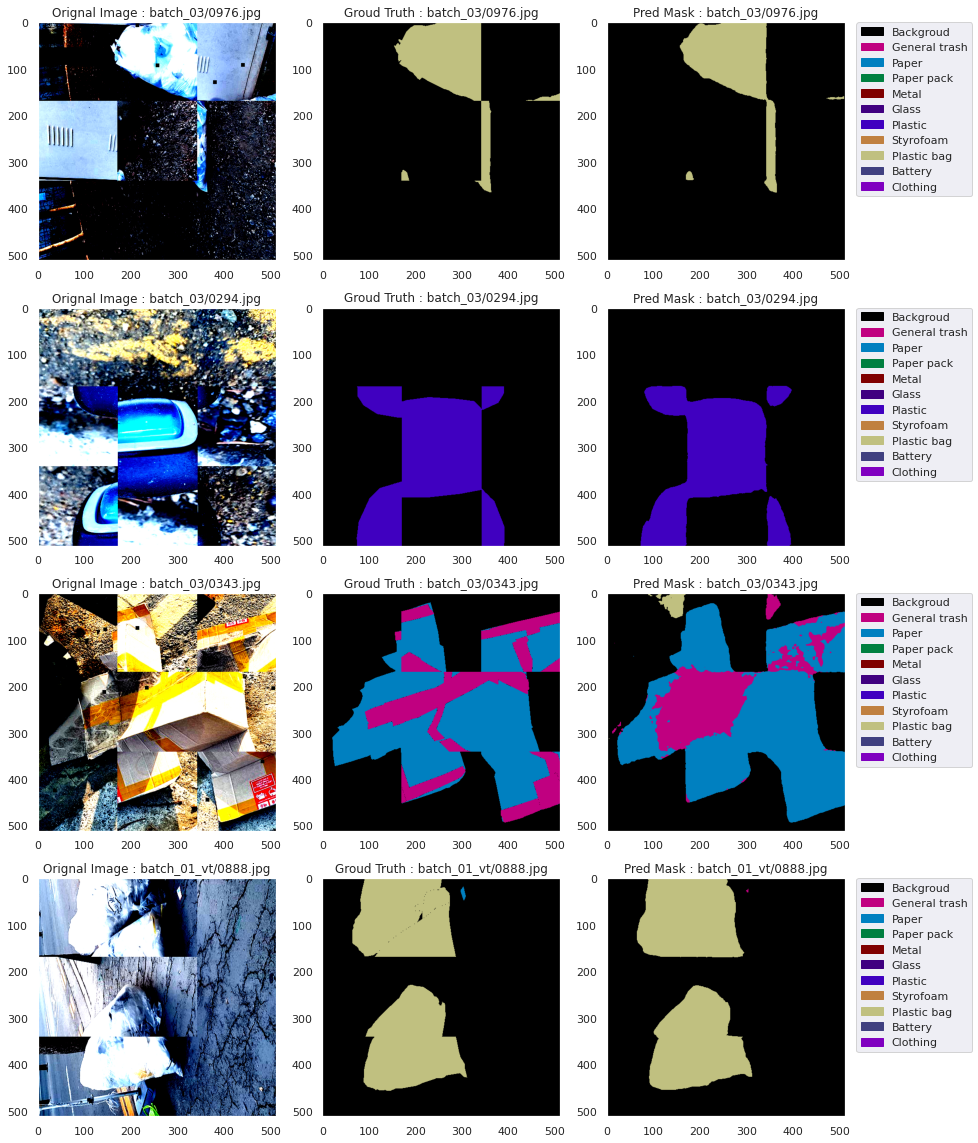

In [26]:
plot_examples(mode="train", batch_id=7, num_examples=4, dataloaer=train_loader)

#### validation set 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


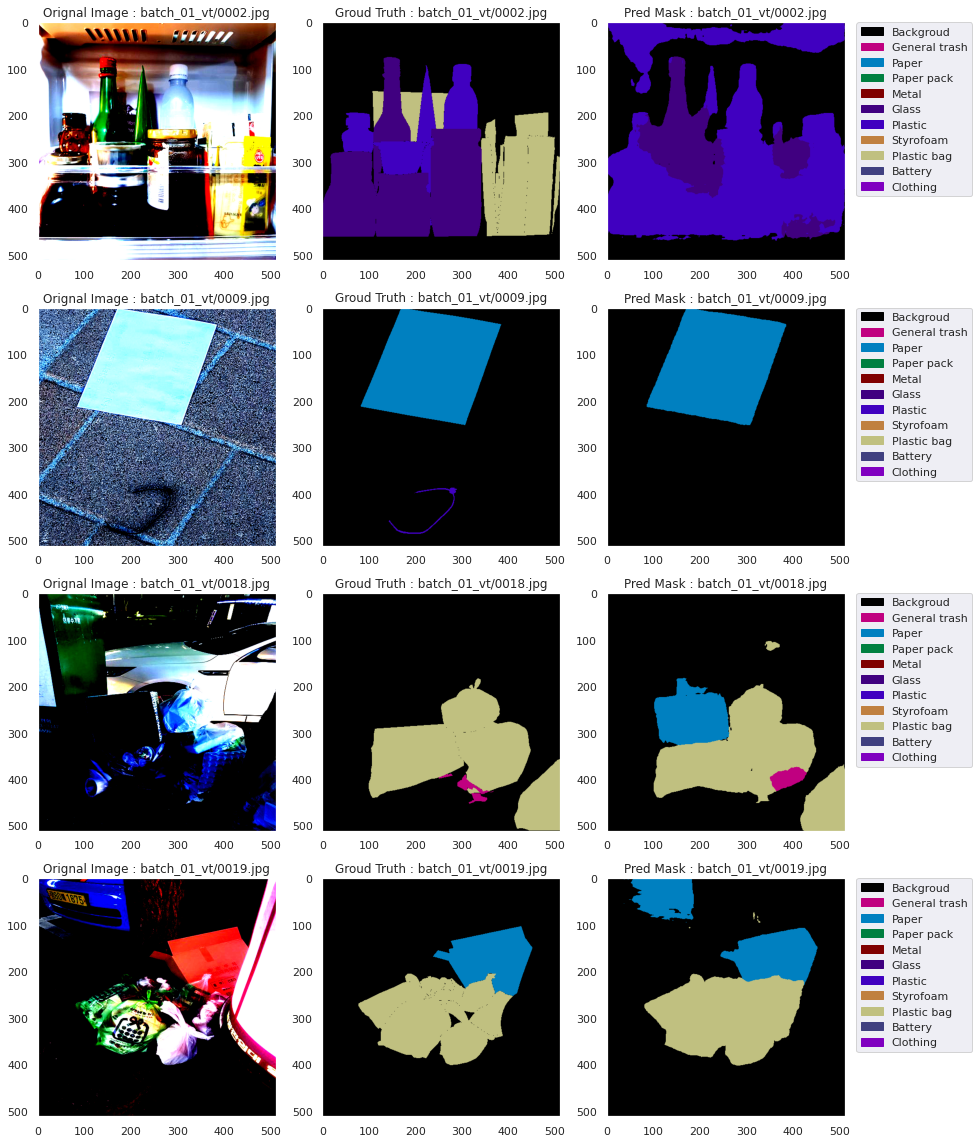

In [27]:
plot_examples(mode="val", batch_id=0, num_examples=4, dataloaer=val_loader)

#### test set 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


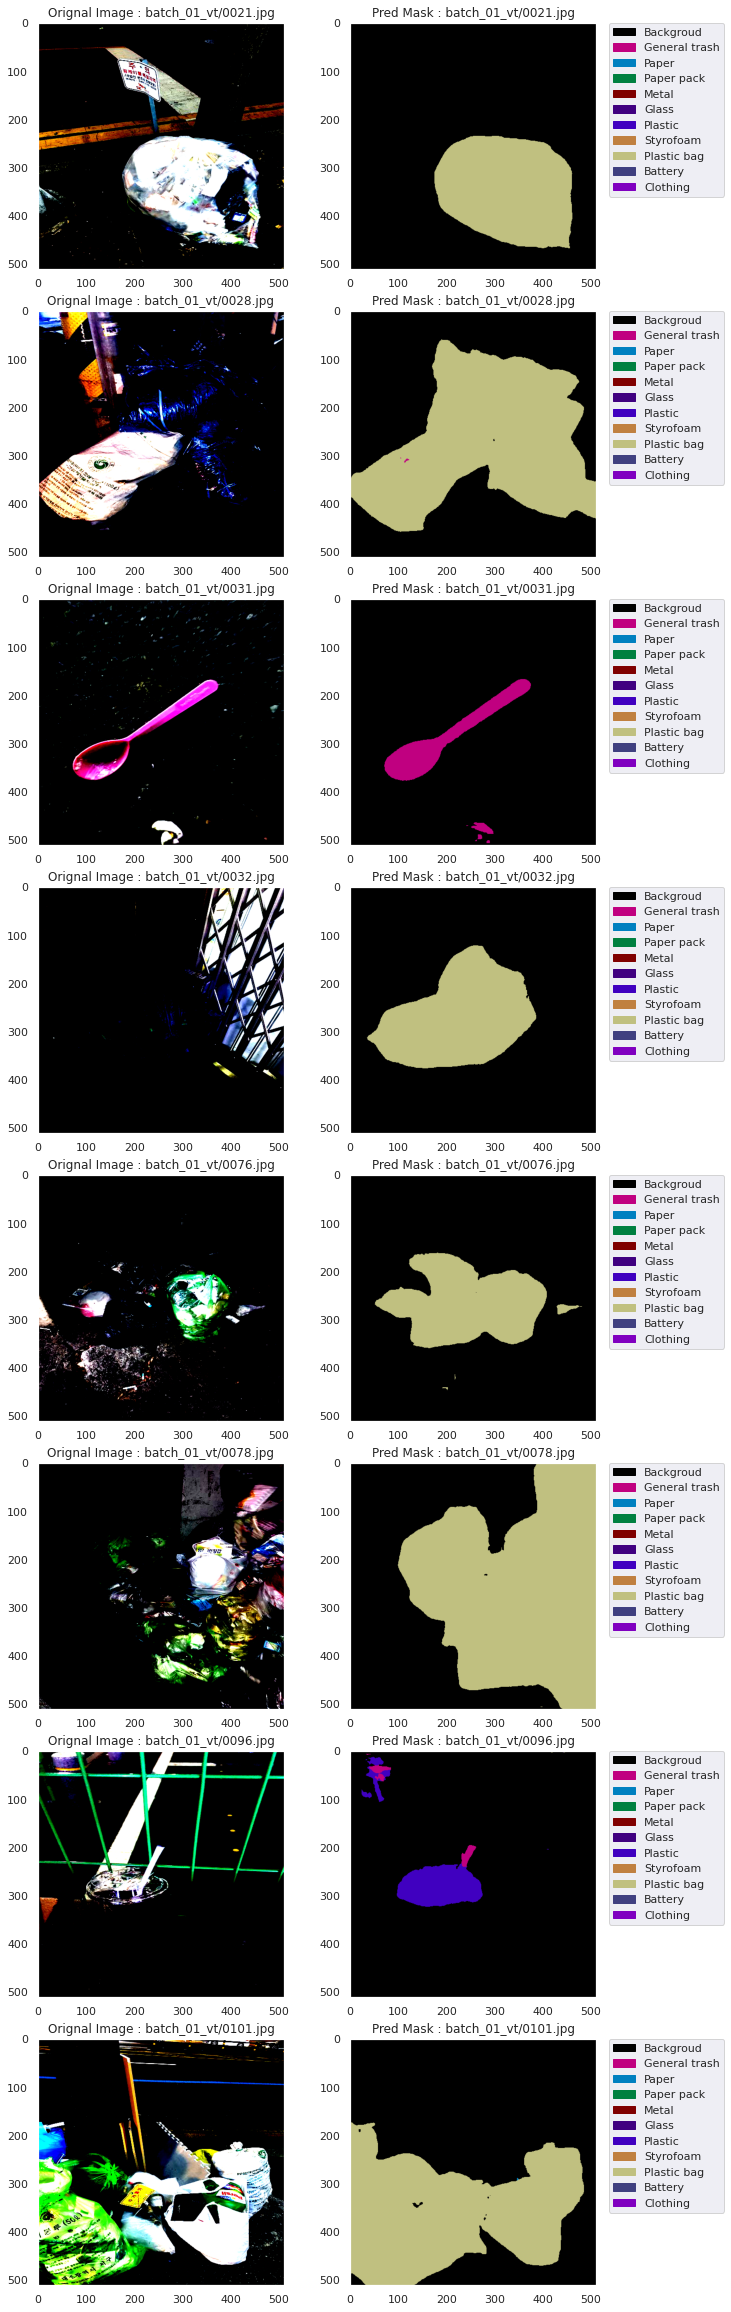

In [28]:
plot_examples(mode="test", batch_id=0, num_examples=8, dataloaer=test_loader)

## submission을 위한 test 함수 정의

In [29]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [30]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/deeplabv3plus_resnext50_epo50.csv", index=False)

  0%|          | 0/52 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 52/52 [05:45<00:00,  5.31s/it]


End prediction.
